In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot##
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import  adfuller
from pmdarima import auto_arima, ARIMA, model_selection
from prophet import Prophet, diagnostics


/home/mano/Manoj/Learning/time_series/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [4]:
path = './AirPassengers.csv'

In [5]:
df = pd.read_csv(path, index_col='Month', parse_dates=True)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [6]:
df = df.rename(columns= {'#Passengers':'y'})

In [7]:
df.columns

Index(['y'], dtype='object')

In [8]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [9]:
df = df.asfreq('MS')

In [10]:
df.head(10)

,y
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [11]:
df.isnull().sum()

y    0
dtype: int64

## Visualization

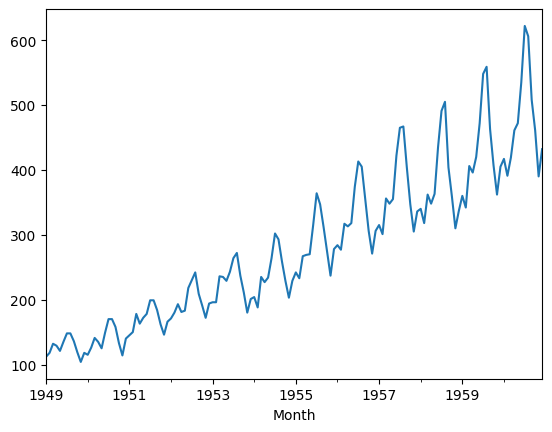

In [12]:
df['y'].plot()
plt.show()

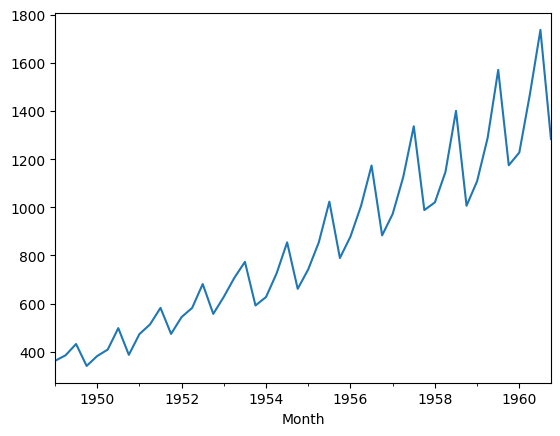

In [13]:
df.resample('QE').sum()['y'].plot()
plt.show()

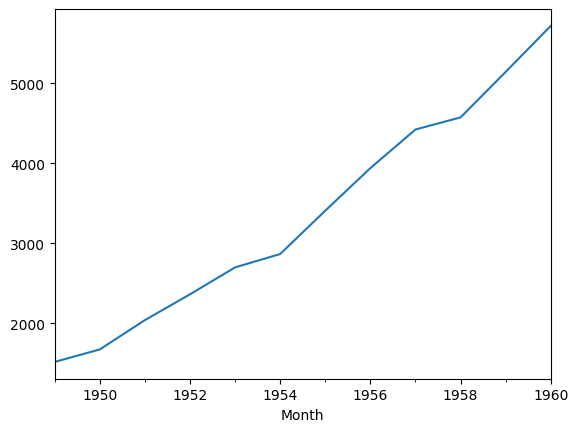

In [14]:
df.resample('YE').sum()['y'].plot()
plt.show()

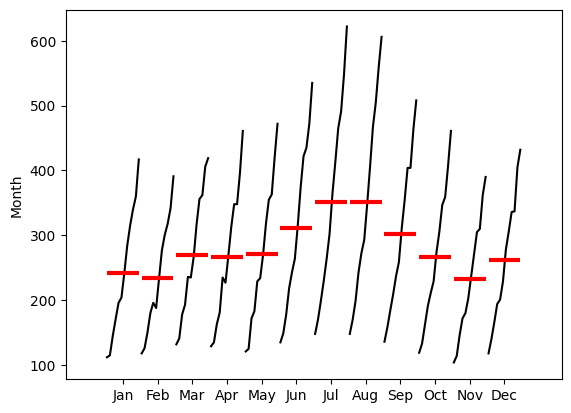

In [15]:
# seasonal samplings
month_plot(df['y'].resample('MS').mean(), ylabel='Month')
plt.show()

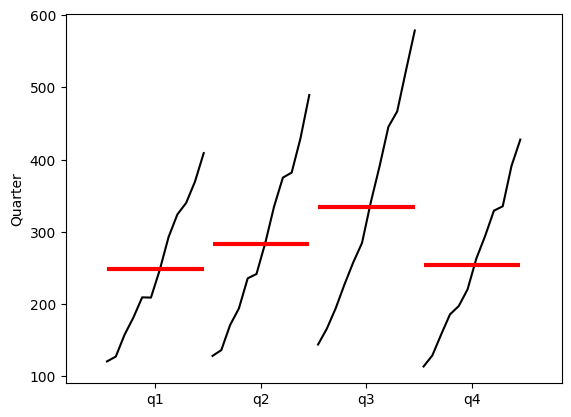

In [16]:
quarter_plot(df['y'].resample('QS').mean(), ylabel='Quarter')
plt.show()

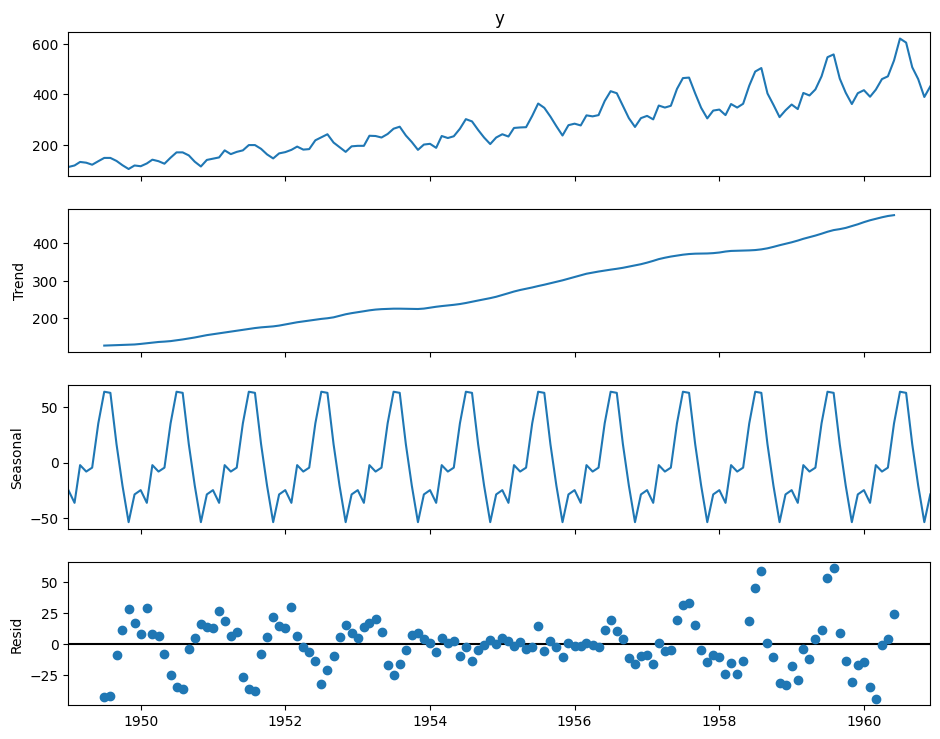

In [17]:
decomposition = seasonal_decompose(df['y'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.show()

## Auto Correlations

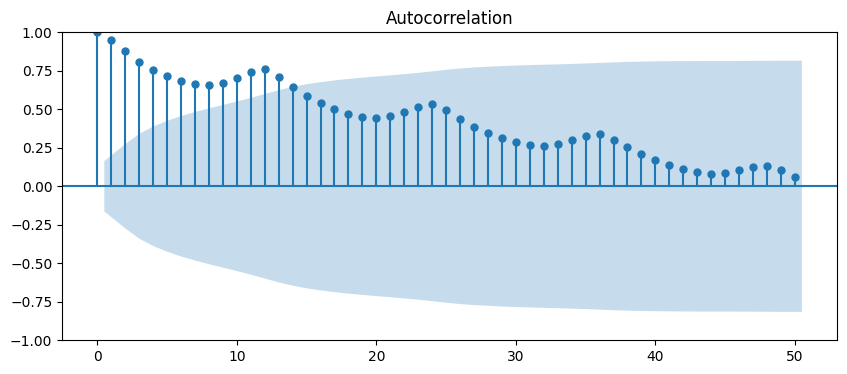

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df['y'], lags=50, ax=ax)
plt.show()

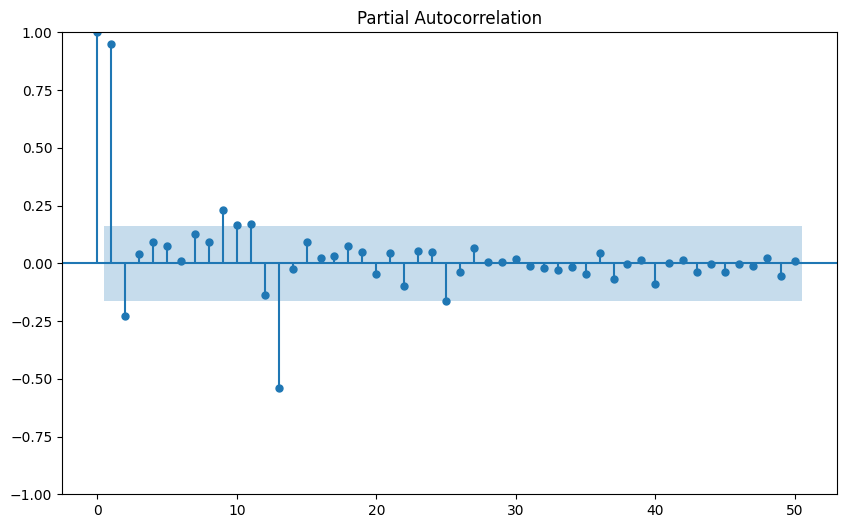

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(df['y'], lags=50, ax=ax)
plt.show()

# Model list
- Exponential model
- ARIMA/SARIMA
- Prophet

In [20]:
periods = 10
train, test = df.iloc[:-periods], df.iloc[-periods:]
test.head()

,y
Month,
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622


In [29]:
def model_assessment(train, test, prediction ,title):
    plt.figure(figsize=(10, 6))
    plt.plot(train, label='train')
    plt.plot(test, label='test')
    plt.plot(prediction, label='Forecast')
    plt.title(f"Train, test and forecast of {title}")
    plt.legend()
    plt.show()

    mae = mean_absolute_error(test, prediction)
    rmse = root_mean_squared_error(test, prediction)
    mape = mean_absolute_percentage_error(test, prediction)

    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAPE: {(mape * 100):.2f} %")

## 1. Exponential smoothing

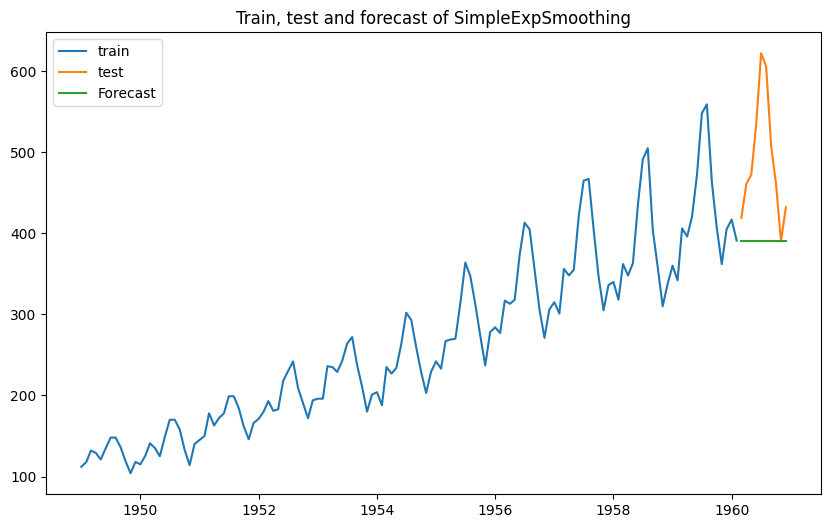

MAE: 99.800
RMSE: 123.628
MAPE: 18.65 %


In [30]:
model_simple = SimpleExpSmoothing(train).fit()
prediction_simple = model_simple.forecast(len(test))
model_assessment(train, test, prediction_simple, 'SimpleExpSmoothing')

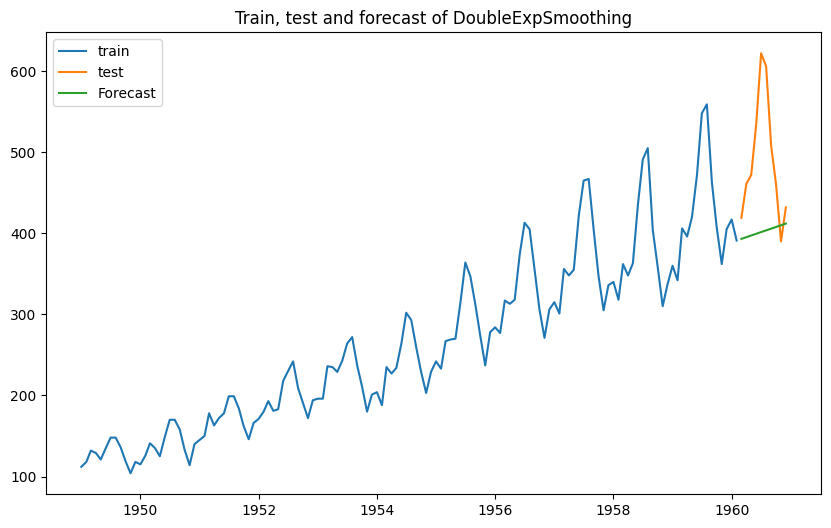

MAE: 92.038
RMSE: 115.180
MAPE: 17.19 %


In [31]:
model_double = ExponentialSmoothing(train, trend="add", seasonal=None).fit()
prediction_double = model_double.forecast(len(test))
model_assessment(train, test, prediction_double, "DoubleExpSmoothing")

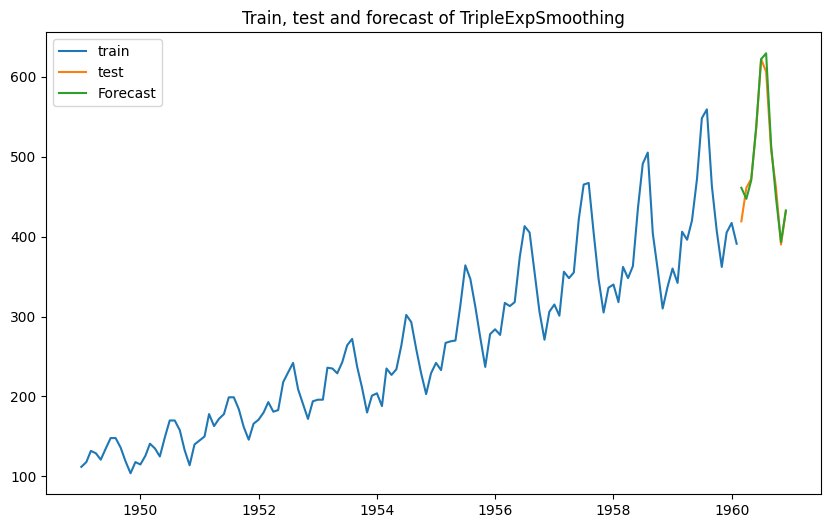

MAE: 10.612
RMSE: 16.436
MAPE: 2.26 %


In [32]:
model_triple = ExponentialSmoothing(train, trend='add', seasonal='mul').fit()
prediction_triple = model_triple.forecast(len(test))
model_assessment(train, test, prediction_triple, "TripleExpSmoothing")

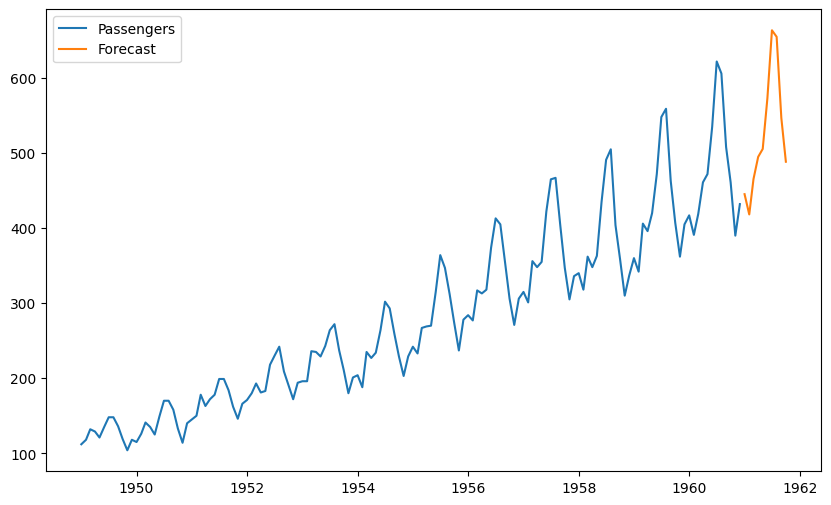

In [56]:
model = ExponentialSmoothing(df['y'], trend='add', seasonal='mul').fit()
prediction = model.forecast(10)
plt.figure(figsize=(10,6))
plt.plot(df['y'], label='Passengers')
plt.plot(prediction, label='Forecast')
plt.legend()
plt.show()

## 2. ARIMA/SARIMA

In [34]:
def check_stationary(y):
    result = adfuller(y)

    pValue = result[1]

    print(f"P-value - {pValue}")

    if pValue < 0.05:
        print("stationary")
    else:
        print("not stationary")

In [35]:
check_stationary(df['y'])

P-value - 0.9918802434376411
not stationary


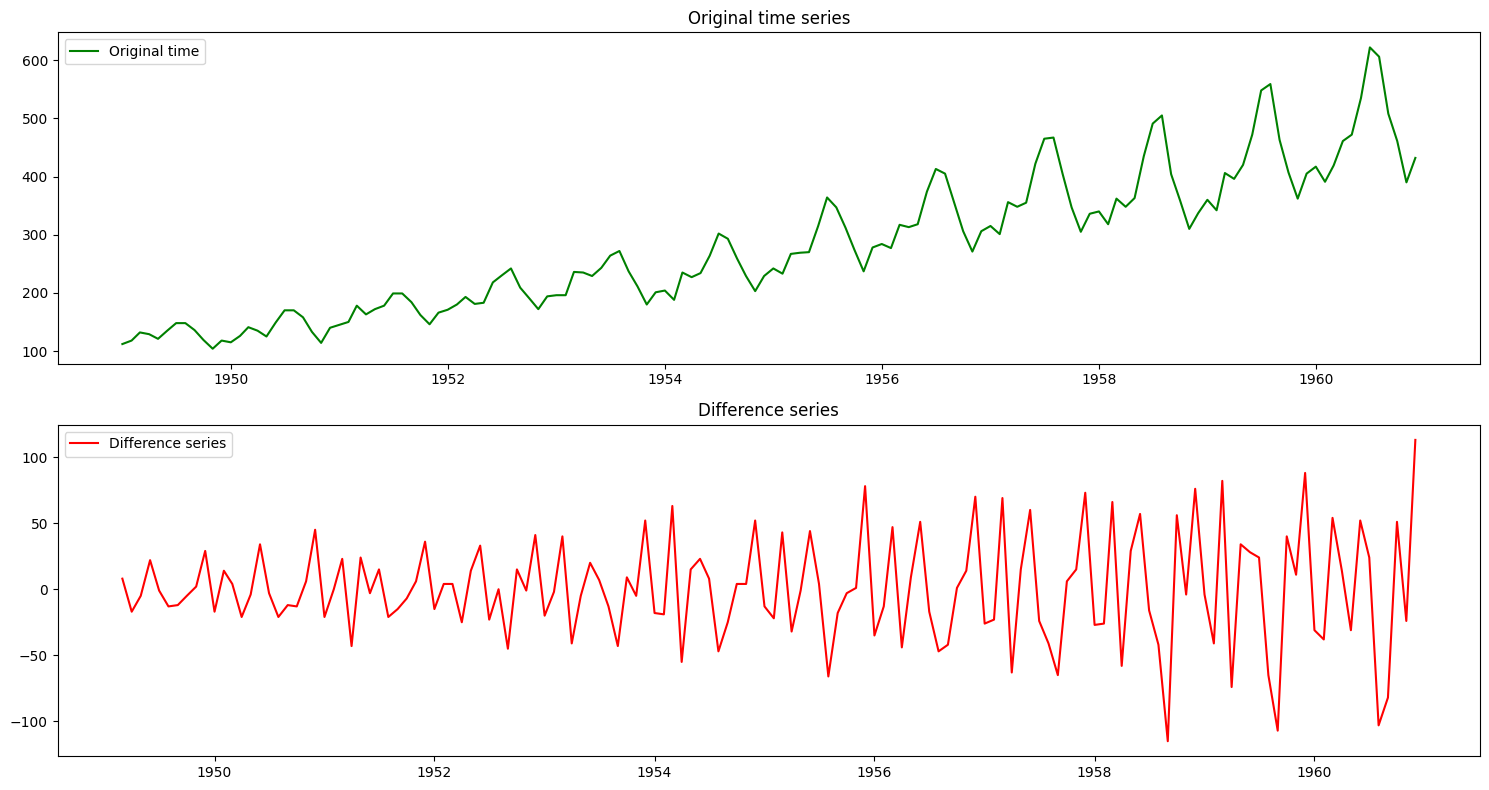

In [41]:
# Make data stationary
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
fig.suptitle("Stationary transformation", fontsize=14, fontweight='bold')

# original
plt.plot(df['y'], label='Original time', color='green')
plt.title('Original time series')
plt.legend()

# 1st difference
plt.subplot(2, 1, 2)
df['diff_1'] = df['y'].diff().dropna()
df['diff_1'] = df['diff_1'].diff().dropna()
plt.plot(df['diff_1'], label='Difference series', color='red')
plt.title('Difference series')
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
check_stationary(df['diff_1'].dropna())

P-value - 2.7328918500140445e-29
stationary


In [58]:
df = df.dropna().ffill()
df.head()

,y,diff_1
Month,,
1949-03-01,132,8.0
1949-04-01,129,-17.0
1949-05-01,121,-5.0
1949-06-01,135,22.0
1949-07-01,148,-1.0


In [59]:
# train and test data set
a_periods = 10
a_train, a_test = df.iloc[:-a_periods], df.iloc[-a_periods:]
a_train.head()

,y,diff_1
Month,,
1949-03-01,132,8.0
1949-04-01,129,-17.0
1949-05-01,121,-5.0
1949-06-01,135,22.0
1949-07-01,148,-1.0


In [60]:
model = auto_arima(train['y'], seasonal=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  134
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -614.521
Date:                Sun, 18 Jan 2026   AIC                           1241.041
Time:                        12:20:05   BIC                           1258.384
Sample:                    01-01-1949   HQIC                          1248.089
                         - 02-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6522      0.127      5.133      0.000       0.403       0.901
ar.L1          1.6050      0.043     37.401      0.000       1.521       1.689
ar.L2         -0.8640      0.039    -21.893      0.000      -0.941      -0.787
ma.L1         -1.7951      0.063    -28.391      0.000      -1.919      -1.671
ma.L2          0.8472      0.063     13.455      0.000       0.724       0.971
sigma2       588.1895     67.471      8.718      0.000     455.949     720.430
===================================================================================
Ljung-Box (L1) (Q):                   1.23   Jarque-Bera (JB):                 3.92
Prob(Q):                              0.27   Prob(JB):                         0.14
Heteroskedasticity (H):               6.29   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
prediction_model = model.predict(n_periods=len(a_test))
prediction_model

1960-03-01    414.126092
1960-04-01    444.990217
1960-05-01    475.199128
1960-06-01    497.670863
1960-07-01    508.290429
1960-08-01    506.571931
1960-09-01    495.290798
1960-10-01    479.321432
1960-11-01    464.089379
1960-12-01    454.091287
Freq: MS, dtype: float64

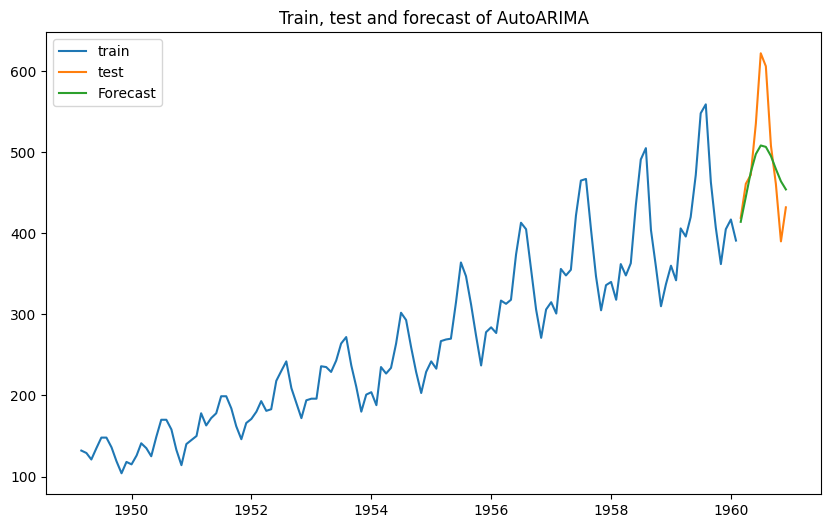

MAE: 40.176
RMSE: 55.654
MAPE: 7.76 %


In [62]:
model_assessment(a_train['y'], a_test['y'], prediction_model, 'AutoARIMA')

In [63]:
s_periods = 10
s_train, s_test = df.iloc[:-periods, 1:], df.iloc[-periods:, 1:]
s_train.head()

,diff_1
Month,
1949-03-01,8.0
1949-04-01,-17.0
1949-05-01,-5.0
1949-06-01,22.0
1949-07-01,-1.0


In [64]:
model_sarimax = auto_arima(a_train['y'], m=7, X=s_train)
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  132
Model:             SARIMAX(5, 1, 0)x(0, 0, [1], 7)   Log Likelihood                -595.032
Date:                             Sun, 18 Jan 2026   AIC                           1208.063
Time:                                     12:20:37   BIC                           1233.940
Sample:                                 03-01-1949   HQIC                          1218.578
                                      - 02-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4861      0.977      3.567      0.000       1.571       5.401
diff_1         0.2168      0.038      5.658      0.000       0.142       0.292
ar.L1          0.2170      0.100      2.163      0.031       0.020       0.414
ar.L2         -0.2295      0.185     -1.243      0.214      -0.591       0.132
ar.L3         -0.3057      0.148     -2.070      0.038      -0.595      -0.016
ar.L4         -0.2612      0.143     -1.829      0.067      -0.541       0.019
ar.L5          0.1680      0.109      1.542      0.123      -0.045       0.381
ma.S.L7       -0.8103      0.084     -9.683      0.000      -0.974      -0.646
sigma2       485.9898     57.811      8.406      0.000     372.682     599.298
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 5.97
Prob(Q):                              0.71   Prob(JB):                         0.05
Heteroskedasticity (H):               8.64   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
prediction_sarimax = model_sarimax.predict(n_periods=len(a_test), X=s_test)
prediction_sarimax

1960-03-01    365.481144
1960-04-01    384.451117
1960-05-01    377.770099
1960-06-01    454.073162
1960-07-01    473.165565
1960-08-01    433.487499
1960-09-01    428.606999
1960-10-01    439.262051
1960-11-01    431.642122
1960-12-01    481.158897
Freq: MS, dtype: float64

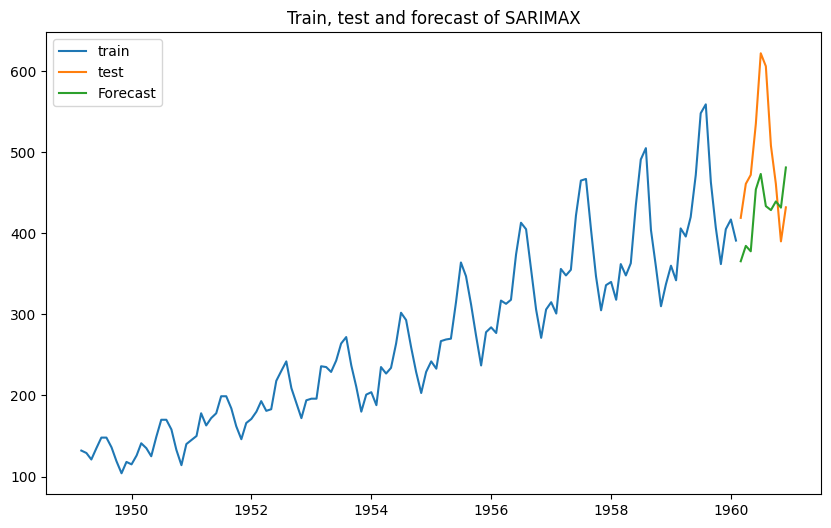

MAE: 81.850
RMSE: 93.269
MAPE: 15.93 %


In [67]:
model_assessment(a_train['y'], a_test['y'], prediction_sarimax, 'SARIMAX')

In [68]:
# define the model to the cv
model_cv = ARIMA(order=(5, 1, 0), seasonal_order=(0, 0, [1], 7))

In [70]:
df.head()

,y,diff_1
Month,,
1949-03-01,132,8.0
1949-04-01,129,-17.0
1949-05-01,121,-5.0
1949-06-01,135,22.0
1949-07-01,148,-1.0


In [80]:
n = len(df)
int(n * 0.7)

99

In [81]:
cv = model_selection.RollingForecastCV(h=10, step=15, initial=int(n * 0.7))

In [ ]:
cv_score = model_selection.cross_val_score(
    model_cv,
    y=df['y'],
    X=df.iloc[:, 1:],
    scoring='mean_squared_error',
    cv=cv,
    verbose=1,
    error_score=1000000,
)

In [83]:
# CV performance
rmse = np.sqrt(np.average(cv_score))
print(f"RMSE: {int(rmse)}")

RMSE: 1000


In [86]:
# Prophet

In [97]:
df_1 = df.copy()
df_1['ds'] = df.index

In [98]:
df.head()

,y,diff_1,ds
Month,,,
1949-03-01,132,8.0,1949-03-01
1949-04-01,129,-17.0,1949-04-01
1949-05-01,121,-5.0,1949-05-01
1949-06-01,135,22.0,1949-06-01
1949-07-01,148,-1.0,1949-07-01


In [108]:
prophet_model = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
)
prophet_model.fit(df_1)

14:14:38 - cmdstanpy - INFO - Chain [1] start processing
14:14:38 - cmdstanpy - INFO - Chain [1] done processing


In [109]:
future = prophet_model.make_future_dataframe(periods=12, freq='MS')
future.tail()

,ds
149,1961-08-01
150,1961-09-01
151,1961-10-01
152,1961-11-01
153,1961-12-01


In [110]:
prophet_forecast = prophet_model.predict(future)
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
149,1961-08-01,649.595845,636.728071,662.998312
150,1961-09-01,552.789460,539.801986,565.748083
151,1961-10-01,488.886870,475.493727,501.740966
152,1961-11-01,424.464237,410.969731,437.691976
153,1961-12-01,473.538225,460.879781,486.685595


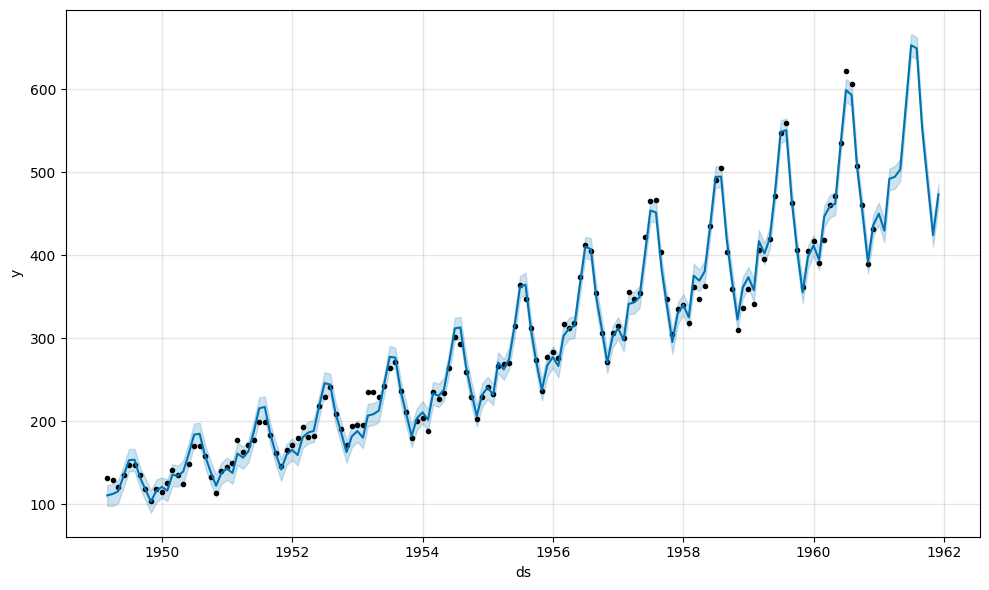

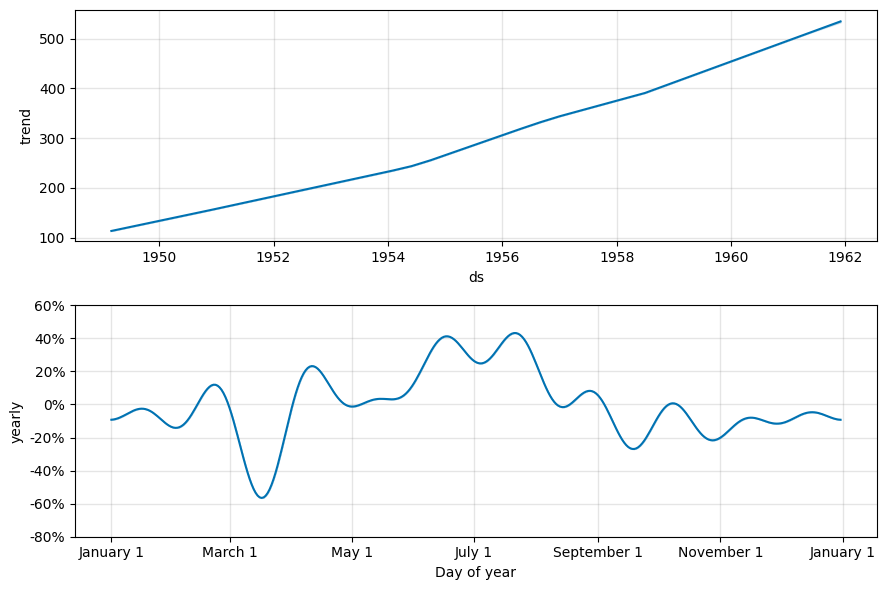

In [111]:
prophet_model.plot(prophet_forecast)
prophet_model.plot_components(prophet_forecast)
plt.show()

In [112]:
# cross validation
prophet_cv = diagnostics.cross_validation(
    prophet_model,
    initial='730 days',
    period='180 days',
    horizon='365 days',
)

  0%|          | 0/18 [00:00<?, ?it/s]14:16:14 - cmdstanpy - INFO - Chain [1] start processing
14:16:15 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 1/18 [00:00<00:02,  6.01it/s]14:16:15 - cmdstanpy - INFO - Chain [1] start processing
14:16:15 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 2/18 [00:00<00:02,  5.60it/s]14:16:15 - cmdstanpy - INFO - Chain [1] start processing
14:16:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 3/18 [00:00<00:02,  5.63it/s]14:16:15 - cmdstanpy - INFO - Chain [1] start processing
14:16:15 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 4/18 [00:00<00:02,  4.90it/s]14:16:15 - cmdstanpy - INFO - Chain [1] start processing
14:16:15 - cmdstanpy - INFO - Chain [1] done processing
 28%|██▊       | 5/18 [00:00<00:02,  4.82it/s]14:16:15 - cmdstanpy - INFO - Chain [1] start processing
14:16:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 6/18 [00:01<00:02,  4.25it/s]14:16:16

In [ ]:
prophet_performance = diagnostics.performance_metrics(prophet_cv)
prophet_performance[['horizon', 'mape', 'rmse', 'mae']].head()